In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
try:
    import tsnecuda as TSNE
except:
    try:
        from MulticoreTSNE import MulticoreTSNE as TSNE
    except:
        import sklearn.manifold as TSNE

In [3]:
from utils_ralib import visualise_images, HDFfile, parse_pose_hdf, plot_euler, TwoSDR, plot_by_cluster

In [4]:
import cupy as cp

rot_scale_trans2D_background_kernel_pars = cp.RawKernel(r'''   
    __device__ inline float restrict2(float x, int nx) {
        while ( x >=  (float)(nx) )  x -= nx;
        while ( x <= -(float)(nx) )  x += nx;
        return x;
    }

    #define  fdata(i,j) fdata[ i-1 + (j-1)*nxdata ]
    __device__ inline float quadri_background(float xx, float yy, int nxdata, int nydata,
        float* fdata, int xnew, int ynew)
    {
        float  x, y, dx0, dy0, f0, c1, c2, c3, c4, c5, dxb, dyb;
        float  quadri;
        int    i, j, ip1, im1, jp1, jm1, ic, jc, hxc, hyc;

        x = xx;
        y = yy;

        // wrap around is not done circulantly; if (x,y) is not in the image, then x = xnew and y = ynew
        if ( (x < 1.0) || ( x >= (float)(nxdata+1) ) || ( y < 1.0 ) || ( y >= (float)(nydata+1) )){
              x = (float)xnew;
              y = (float)ynew;
        }


        i   = (int) x;
        j   = (int) y;

        dx0 = x - i;
        dy0 = y - j;

        ip1 = i + 1;
        im1 = i - 1;
        jp1 = j + 1;
        jm1 = j - 1;

        if (ip1 > nxdata) ip1 -= nxdata;
        if (im1 < 1)      im1 += nxdata;
        if (jp1 > nydata) jp1 -= nydata;
        if (jm1 < 1)      jm1 += nydata;

        f0  = fdata(i,j);
        c1  = fdata(ip1,j) - f0;
        c2  = (c1 - f0 + fdata(im1,j)) * 0.5f;
        c3  = fdata(i,jp1) - f0;
        c4  = (c3 - f0 + fdata(i,jm1)) * 0.5f;

        dxb = dx0 - 1;
        dyb = dy0 - 1;

        // hxc & hyc are either 1 or -1
        if (dx0 >= 0) hxc = 1; else hxc = -1;
        if (dy0 >= 0) hyc = 1; else hyc = -1;

        ic  = i + hxc;
        jc  = j + hyc;

        if (ic > nxdata) ic -= nxdata;  else if (ic < 1) ic += nxdata;
        if (jc > nydata) jc -= nydata;  else if (jc < 1) jc += nydata;

        c5  =  ( (fdata(ic,jc) - f0 - hxc * c1 - (hxc * (hxc - 1.0f)) * c2
            - hyc * c3 - (hyc * (hyc - 1.0f)) * c4) * (hxc * hyc));


        quadri = f0 + dx0 * (c1 + dxb * c2 + dy0 * c5) + dy0 * (c3 + dyb * c4);

        return quadri;
    }
    #define M_PI 3.14159265358979323846f
    extern "C" __global__
    void rot_scale_trans2D_background(float* dst, float* src, int nx, int ny, int c,
        float* angDeg, float* delx, float* dely, float* scale) 
    {
        int ix = blockIdx.x * blockDim.x + threadIdx.x;
        int iy = blockIdx.y * blockDim.y + threadIdx.y;
        int  z = blockIdx.z * blockDim.z + threadIdx.z;
        
        if (ix < nx && iy < ny && z < c) {

            src = &src[nx * ny * z];
            dst = &dst[nx * ny * z];

            float ang=angDeg[z]*M_PI/180.0f;

            if (0.0f == scale[z]) scale[z] = 1.0f; // silently fix common user error

            delx[z] = restrict2(delx[z], nx);
            dely[z] = restrict2(dely[z], ny);

            // center of image
            int xc = nx/2;
            int yc = ny/2;
            // shifted center for rotation
            float shiftxc = xc + delx[z];
            float shiftyc = yc + dely[z];
            // trig
            float cang = cos(ang);
            float sang = sin(ang);

            float y = float(iy) - shiftyc;
            float ycang = y*cang/scale[z] + yc;
            float ysang = -y*sang/scale[z] + xc;

            float x = float(ix) - shiftxc;
            float xold = x*cang/scale[z] + ysang ;
            float yold = x*sang/scale[z] + ycang ;

            int pos = iy * nx + ix;
            float tmp = quadri_background(xold+1.0f, yold+1.0f, nx, ny, src, ix+1, iy+1);
            //tmp = (tmp > 255) ? 255:tmp;
            //tmp = (tmp <   0) ?   0:tmp;
            dst[pos] = (float)tmp;
        }
    }
    ''', 'rot_scale_trans2D_background')

def rot_shift_2d_cupy(images, angDegs, delxs, delys , mirrors , scales):
    in_gpu_array = cp.array(images)
    out_gpu_array = cp.zeros(in_gpu_array.shape, cp.float32)
    
    in_gpu_angDegs = cp.array(angDegs)
    in_gpu_delxs = cp.array(delxs)
    in_gpu_delys = cp.array(delys)
    in_gpu_scales = cp.array(scales)

    (c, h, w) = in_gpu_array.shape
    block = (16, 16, 4)
    grid = ((w + 15)//16, (h + 15)//16, (c+3)//4)
    rot_scale_trans2D_background_kernel_pars(grid, block,
                                       (out_gpu_array, in_gpu_array, w, h, c, 
                                        in_gpu_angDegs, in_gpu_delxs, in_gpu_delys, in_gpu_scales))
    start = 1 - h%2    
    for i in range(len(images)):
        if int(mirrors[i]) == 1:
            out_gpu_array[i][:,start:] = cp.flip(out_gpu_array[i][:,start:],1)
    out = cp.asnumpy(out_gpu_array)
    
    return out

In [5]:
stack_name = "rib_images22.hdf"
params2d_name = "params_70s.txt"

In [6]:
data = HDFfile.load(stack_name, params2d_name)

utils_ralib.py:32: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  df = pd.read_table(params_file, header=None, delim_whitespace=True, names=headers)


In [7]:
data.df

,idx,angle_psi,shift_x,shift_y,mirror,class
0,0,1.968414,1.102456,2.963881,0,0
1,1,233.460175,1.578082,-3.809154,1,1
2,2,329.555145,-0.809310,5.324004,0,0
3,3,5.601624,-4.273732,-2.595230,0,2
4,4,1.216797,1.063481,2.978088,0,0
5,5,235.121063,3.431066,-4.922173,1,1
6,6,5.440613,-3.176113,-1.706548,0,2
7,7,3.958191,-4.197544,-2.716730,0,2
8,8,14.653503,0.044418,4.122866,1,1
9,9,87.390625,2.769257,5.131395,0,2


In [8]:
arr = data.get_particles()

In [9]:
arr.shape

(150, 130, 130)

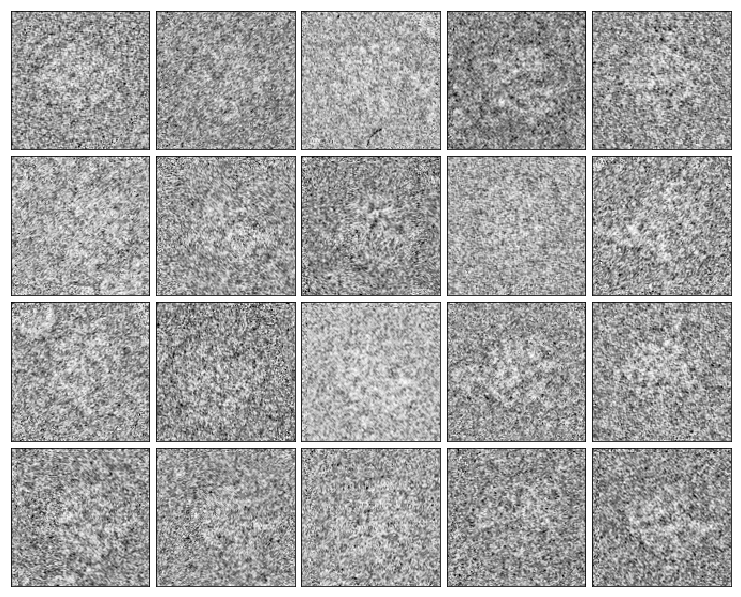

In [10]:
visualise_images(arr, 20,5, False)

In [11]:
euler, trans, rot, classes = parse_pose_hdf(data.df)

2020-11-05 14:57:53     Euler angles (Psi):
2020-11-05 14:57:53     [0.       0.       1.968414]
2020-11-05 14:57:53     Converting to rotation matrix:
2020-11-05 14:57:53     [[ 0.99940991  0.03434855  0.        ]
 [-0.03434855  0.99940991 -0.        ]
 [ 0.         -0.          1.        ]]
2020-11-05 14:57:53     Translations:
2020-11-05 14:57:53     [1.102456 2.963881]
2020-11-05 14:57:53     Class:
2020-11-05 14:57:53     0


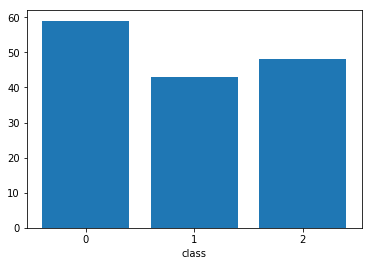

In [12]:
labels, counts = np.unique(classes, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.xlabel('class')
plt.savefig("class.pdf")

/usr/local/EMAN2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


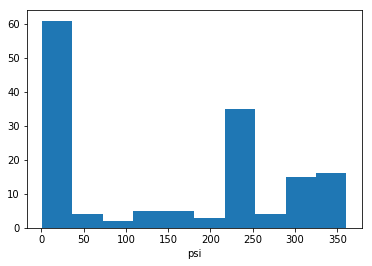

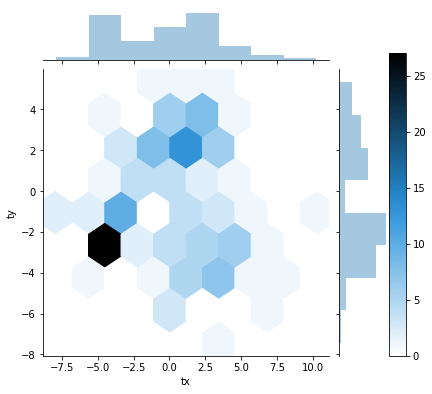

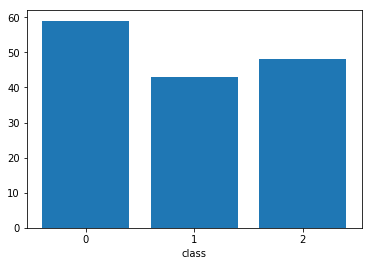

In [13]:
plot_euler(euler, trans, classes, plot_class = True)

In [14]:
arr.shape

(150, 130, 130)

In [15]:
factors,  Gt, At, Bt, mY = TwoSDR(arr, 25, 25, 50)
tsne = TSNE()
Y = tsne.fit_transform(factors)

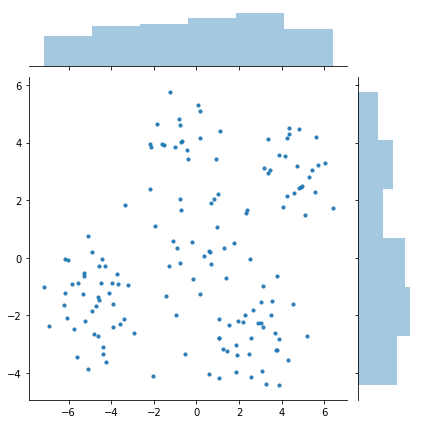

In [16]:
sns_plot = sns.jointplot(Y[:,0], Y[:,1], alpha=.9, s=10)

In [17]:
scales = np.array([1 for i in range(len(arr))])
arr_transformed = rot_shift_2d_cupy(arr, data.df['angle_psi'].to_numpy().astype(np.float32),\
                                    data.df['shift_x'].to_numpy().astype(np.float32),\
                                    data.df['shift_y'].to_numpy().astype(np.float32),\
                                    data.df['mirror'].to_numpy().astype(np.float32), scales)

In [18]:
factors,  Gt, At, Bt, mY = TwoSDR(arr_transformed, 25, 25, 50)
tsne = TSNE()
Y2 = tsne.fit_transform(factors)

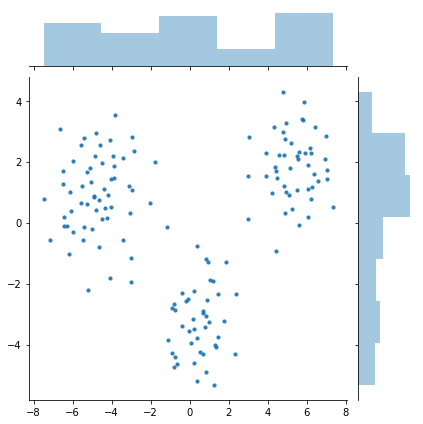

In [19]:
sns_plot = sns.jointplot(Y2[:,0], Y2[:,1], alpha=.9, s=10)

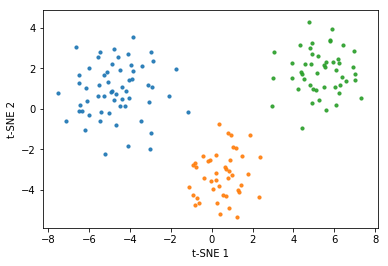

In [20]:
K = len(set(data.df['class'].to_numpy()))
plot_by_cluster(Y2[:,0], Y2[:,1], K, 
                         data.df['class'].to_numpy())
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig('tsne3.pdf') 